## These following lines uses to extract skills based on professor's code

### Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("../NLPdata/resume.csv")

In [2]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

In [3]:
import spacy
print(spacy.__version__)

3.5.0


In [ ]:
# run this in terminal python -m spacy download en_core_web_sm

### Load skills data

In [8]:
import en_core_web_sm
import spacy

nlp = en_core_web_sm.load()
skill_path = "../NLPdata/skills.jsonl"

In [9]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [10]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

### Extract skills from resume.csv

In [11]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1144,12897903,CONSULTANT Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT
1173,12526702,CONSULTANT Profile \n\nSkil...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT
1632,11409460,BUYER/PLANNER Summary De...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
2015,19928941,CAR SALESMAN Summary of S...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
922,30437583,PROGRAM ANALYST Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE


In [12]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [13]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         HR GENERALIST       Experience     08/2017   to   Current     HR GENERALIST    Company Name   －   City  ,   State      Recruited to help open new company sales team in TX and NC, guiding senior management on pay and.  compensation for contract positions.  Worked with senior leadership to cr'

In [14]:
preprocessing(random_resume[:300])

'hr generalist experience 08/2017 current hr generalist company name － city state recruit help open new company sale team tx nc guide senior management pay compensation contract position work senior leadership cr'

In [15]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [16]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1144,12897903,CONSULTANT Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant highlights employee relation perfor...
1173,12526702,CONSULTANT Profile \n\nSkil...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant profile skilled professional 15 yea...
1632,11409460,BUYER/PLANNER Summary De...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,buyer planner summary detail orient analytical...
2015,19928941,CAR SALESMAN Summary of S...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,car salesman summary skills administration man...
922,30437583,PROGRAM ANALYST Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,program analyst professional summary as key me...


### Let's really extract skills!!

In [17]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [18]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
1144,12897903,CONSULTANT Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant highlights employee relation perfor...


In [19]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [20]:
df_resume.Skills.iloc[0]

['resource allocation',
 'medium',
 'business administration',
 'business',
 'design']

### Visualization

In [21]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [22]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(44, 6)

In [23]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [24]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

counting

OrderedDict([('support', 39),
             ('software', 35),
             ('design', 35),
             ('business', 35),
             ('server', 27),
             ('windows', 26),
             ('security', 25),
             ('project management', 22),
             ('database', 21),
             ('documentation', 18)])

<BarContainer object of 10 artists>

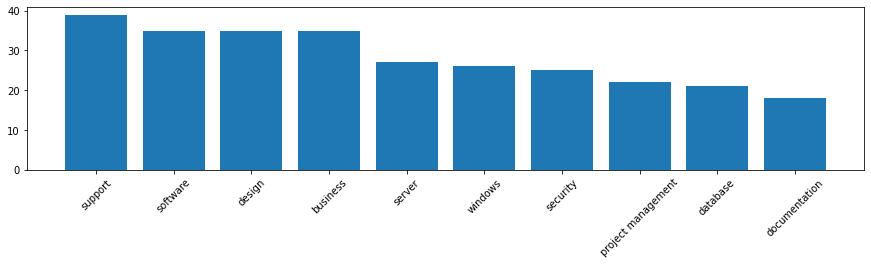

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

### Name Entity Recognition

In [26]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [27]:
doc = nlp(text)

In [28]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [29]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

### Let's load someone_cv.pdf

In [30]:
from PyPDF2 import PdfReader

#pip install PyPDF2

reader = PdfReader("../NLPdata/someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [31]:
text = preprocessing(text)

In [32]:
doc = nlp(text)

In [33]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [34]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'algorithms', 'deep learning', 'engineering', 'ai', 'computer science', 'artificial intelligence'}


## Further study on extracting education

In [190]:
import en_core_web_sm
import spacy

nlp = en_core_web_sm.load()
skill_path = "../NLPdata/education_demo.jsonl"

In [191]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [192]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [193]:
def get_education(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know education
    
    education = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is EDUCATION, then we append to some list
        if ent.label_ == "EDUCATION":
            education.append(ent.text)
    
    return education

reader = PdfReader("../NLPdata/someone_cv.pdf")
page = reader.pages[0] #let's try first page
text = page.extract_text()
text = preprocessing(text)

In [194]:
education = get_education(text)

In [195]:
education

['assistant', 'associate', 'assistant']

In [196]:
doc = nlp(text)
colors = {"EDUCATION": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [197]:
page = reader.pages[5] #let's try page 6
text = page.extract_text()
text = preprocessing(text)

In [198]:
education = get_education(text)

education

['diplomas', 'doctoral', 'doctoral', 'msc']

In [199]:
doc = nlp(text)

In [200]:
colors = {"EDUCATION": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)